In [84]:
import numpy as np
import torch
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
import time
import ot
import ot.plot
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn import manifold
import matplotlib.pyplot as pl
import umap
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

In [2]:
import sys
sys.path.append('../code/')
from HierarchicalOT import load_wmd_data,change_embeddings,reduce_vocab,fit_topics,sparseOT
from sinkhorn_iterates import sinkhorn
from linear_solver import UOT_W
from utils import plot2D_plan,plot2D_plan_vocab

# t-SNE and U-map representation of Wasserstein distance matrices

In [35]:
data_path = './data/WordMoverDistances/'
embeddings_path = './data/WordMoverDistances/glove.6B/glove.6B.300d.txt'

# Pick a dataset (n_doc,n_vocab)
#data_name = 'bbcsport-emd_tr_te_split.mat' #(737,3657)
data_name = 'twitter-emd_tr_te_split.mat' #(3108, 1205)
#data_name = 'r8-emd_tr_te3.mat' # (7674,5495)
#data_name = 'amazon-emd_tr_te_split.mat' #(8000, 16753)
#data_name = 'classic-emd_tr_te_split.mat' # (7093, 5813)
#data_name = 'ohsumed-emd_tr_te_ix.mat'# (9152, 8261)

vocab, embed_vocab, bow_data, y = load_wmd_data(data_path + data_name)
y = y - 1
vocab, embed_vocab, bow_data = change_embeddings(vocab, bow_data, embeddings_path) # embed in Glove

vocab, embed_vocab, bow_data = reduce_vocab(bow_data, vocab, embed_vocab, embed_aggregate='mean') # Reduce vocabulary by removing short words, stop words, and stemming (root words?)
embeddings = np.array([embed_vocab[w] for w in vocab])
cost_embeddings = euclidean_distances(embeddings, embeddings) ** 2 # Matrix of word embeddings: nb_vocab x 300

In [36]:
bow_data.shape,y.min(),y.max()

((3108, 1205), 0, 2)

In [55]:
label_color=[]
y_label=["1","2","3","4","5","6","7","8","9","10"]
for i in range(y.shape[0]):
    label_color+=["C%i"%y[i]]

if data_name == 'bbcsport-emd_tr_te_split.mat':
    y_label[0:5]=["Athletism","Cricket","Football","Rubgy","Tenis"] # Label for BBC
elif data_name =='twitter-emd_tr_te_split.mat':
    y_label[0:3]=["Positive","Negative","Neutral"]# Label for Twitter
elif data_name=='r8-emd_tr_te3.mat':
    y_label[0:8]=["1","2","3","4","5","6","7","8"]#
elif data_name=='amazon-emd_tr_te_split.mat':
    y_label[0:4]=["Books","Dvd","Electronics","Kitchen"]# Label for Amazon
elif data_name=='classic-emd_tr_te_split.mat':
    y_label[0:4]=["1","2","3","4"]#
elif data_name=='ohsumed-emd_tr_te_ix.mat':
    y_label=["1","2","3","4","5","6","7","8","9","10"]# 

### WMD

In [56]:
WMD=np.loadtxt("result/WordMoverDistances/WMD_"+data_name+".txt")    

In [57]:
#WMD_low = manifold.TSNE(n_components=2,random_state=0,metric="precomputed",early_exaggeration=50.0).fit_transform(WMD)
WMD_low = umap.UMAP(random_state=0,metric="precomputed").fit_transform(WMD)

/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


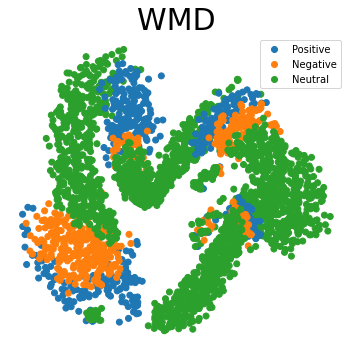

In [58]:
pl.figure(figsize=(5,5))
pl.scatter(WMD_low[:,0],WMD_low[:,1],c=label_color)
label1 = Line2D([0], [0], label=y_label[0], marker='o', color='C0', linestyle='')
label2 = Line2D([0], [0], label=y_label[1], marker='o', color='C1', linestyle='')
label3 = Line2D([0], [0], label=y_label[2], marker='o', color='C2', linestyle='')
label4 = Line2D([0], [0], label=y_label[3], marker='o', color='C3', linestyle='')
label5 = Line2D([0], [0], label=y_label[4], marker='o', color='C4', linestyle='')
label6 = Line2D([0], [0], label=y_label[4], marker='o', color='C5', linestyle='')
label7 = Line2D([0], [0], label=y_label[4], marker='o', color='C6', linestyle='')
label8 = Line2D([0], [0], label=y_label[4], marker='o', color='C7', linestyle='')
label9 = Line2D([0], [0], label=y_label[4], marker='o', color='C8', linestyle='')
label10 = Line2D([0], [0], label=y_label[4], marker='o', color='C9', linestyle='')
handles, labels = pl.gca().get_legend_handles_labels()
if data_name == 'bbcsport-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4,label5])
elif data_name =='twitter-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3])
elif data_name=='r8-emd_tr_te3.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8])
elif data_name=='amazon-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='classic-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='ohsumed-emd_tr_te_ix.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8,label9,label10])
pl.title("WMD",size=30)
pl.axis('off')
pl.tight_layout()
pl.legend(handles=handles)
pl.savefig("../Figures/WMD/WMD_"+data_name+".pdf",bbox_inches='tight')

### HOTT

In [59]:
HOTT=np.loadtxt("result/WordMoverDistances/HOTT_"+data_name+".txt")
HOTT=abs(HOTT)

In [60]:
#HOTT_low = manifold.TSNE(n_components=2,metric="precomputed",early_exaggeration=50.0,random_state=0).fit_transform(HOTT)
HOTT_low = umap.UMAP(random_state=0,metric="precomputed").fit_transform(HOTT)

/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


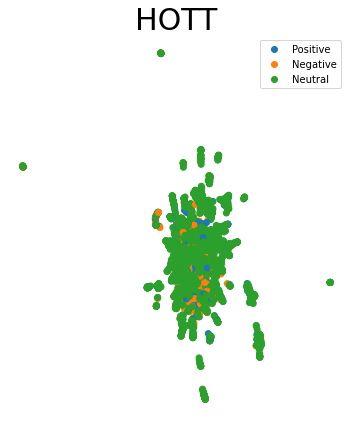

In [61]:
pl.figure(figsize=(5,6))
pl.scatter(HOTT_low[:,0],HOTT_low[:,1],c=label_color)
label1 = Line2D([0], [0], label=y_label[0], marker='o', color='C0', linestyle='')
label2 = Line2D([0], [0], label=y_label[1], marker='o', color='C1', linestyle='')
label3 = Line2D([0], [0], label=y_label[2], marker='o', color='C2', linestyle='')
label4 = Line2D([0], [0], label=y_label[3], marker='o', color='C3', linestyle='')
label5 = Line2D([0], [0], label=y_label[4], marker='o', color='C4', linestyle='')
label6 = Line2D([0], [0], label=y_label[4], marker='o', color='C5', linestyle='')
label7 = Line2D([0], [0], label=y_label[4], marker='o', color='C6', linestyle='')
label8 = Line2D([0], [0], label=y_label[4], marker='o', color='C7', linestyle='')
label9 = Line2D([0], [0], label=y_label[4], marker='o', color='C8', linestyle='')
label10 = Line2D([0], [0], label=y_label[4], marker='o', color='C9', linestyle='')
handles, labels = pl.gca().get_legend_handles_labels()
if data_name == 'bbcsport-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4,label5])
elif data_name =='twitter-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3])
elif data_name=='r8-emd_tr_te3.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8])
elif data_name=='amazon-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='classic-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='ohsumed-emd_tr_te_ix.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8,label9,label10])
pl.title("HOTT",size=30)
pl.axis('off')
pl.tight_layout()
pl.legend(handles=handles)
pl.savefig("../Figures/WMD/HOTT_"+data_name+".pdf",bbox_inches='tight')

### UOT linear solver

In [68]:
l=1 # in [.1,.5,1,10]
UOT1=np.loadtxt("result/WordMoverDistances/UOTP_"+data_name+"_"+str(l)+".txt") #Only with the plan
UOT2=np.loadtxt("result/WordMoverDistances/UOT_"+data_name+"_"+str(l)+".txt") #Plan and divergences
UOT1,UOT2=abs(UOT1),abs(UOT2)

In [69]:
#WMD1_low = manifold.TSNE(n_components=2,metric="precomputed",early_exaggeration=50.0,random_state=0).fit_transform(WMDuot1)
#WMD2_low = manifold.TSNE(n_components=2,metric="precomputed",early_exaggeration=50.0,random_state=0).fit_transform(WMDuot2)

WMD1_low = umap.UMAP(random_state=0,metric="precomputed").fit_transform(UOT1)
WMD2_low = umap.UMAP(random_state=0,metric="precomputed").fit_transform(UOT2)

/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


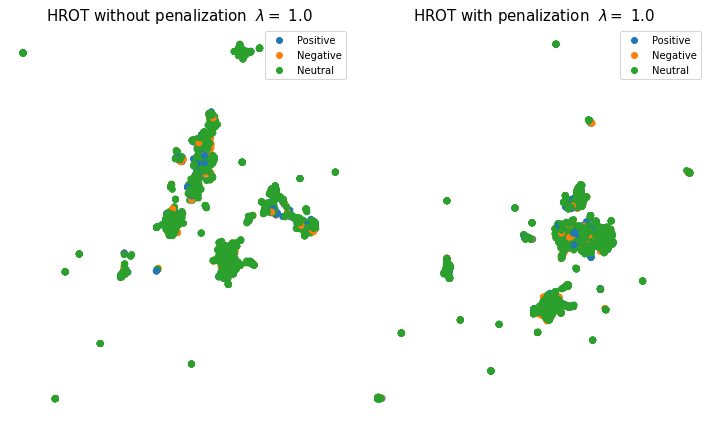

In [70]:
pl.figure(figsize=(10,6))
pl.subplot(1,2,1)
pl.scatter(WMD1_low[:,0],WMD1_low[:,1],c=label_color)
label1 = Line2D([0], [0], label=y_label[0], marker='o', color='C0', linestyle='')
label2 = Line2D([0], [0], label=y_label[1], marker='o', color='C1', linestyle='')
label3 = Line2D([0], [0], label=y_label[2], marker='o', color='C2', linestyle='')
label4 = Line2D([0], [0], label=y_label[3], marker='o', color='C3', linestyle='')
label5 = Line2D([0], [0], label=y_label[4], marker='o', color='C4', linestyle='')
label6 = Line2D([0], [0], label=y_label[4], marker='o', color='C5', linestyle='')
label7 = Line2D([0], [0], label=y_label[4], marker='o', color='C6', linestyle='')
label8 = Line2D([0], [0], label=y_label[4], marker='o', color='C7', linestyle='')
label9 = Line2D([0], [0], label=y_label[4], marker='o', color='C8', linestyle='')
label10 = Line2D([0], [0], label=y_label[4], marker='o', color='C9', linestyle='')
handles, labels = pl.gca().get_legend_handles_labels()
if data_name == 'bbcsport-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4,label5])
elif data_name =='twitter-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3])
elif data_name=='r8-emd_tr_te3.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8])
elif data_name=='amazon-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='classic-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='ohsumed-emd_tr_te_ix.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8,label9,label10])
pl.title("HROT without penalization  $\lambda =$ %1.1f"%l,size=15)
pl.axis('off')
pl.tight_layout()
pl.legend(handles=handles)
pl.subplot(1,2,2)
pl.scatter(WMD2_low[:,0],WMD2_low[:,1],c=label_color)
label1 = Line2D([0], [0], label=y_label[0], marker='o', color='C0', linestyle='')
label2 = Line2D([0], [0], label=y_label[1], marker='o', color='C1', linestyle='')
label3 = Line2D([0], [0], label=y_label[2], marker='o', color='C2', linestyle='')
label4 = Line2D([0], [0], label=y_label[3], marker='o', color='C3', linestyle='')
label5 = Line2D([0], [0], label=y_label[4], marker='o', color='C4', linestyle='')
label6 = Line2D([0], [0], label=y_label[4], marker='o', color='C5', linestyle='')
label7 = Line2D([0], [0], label=y_label[4], marker='o', color='C6', linestyle='')
label8 = Line2D([0], [0], label=y_label[4], marker='o', color='C7', linestyle='')
label9 = Line2D([0], [0], label=y_label[4], marker='o', color='C8', linestyle='')
label10 = Line2D([0], [0], label=y_label[4], marker='o', color='C9', linestyle='')
handles, labels = pl.gca().get_legend_handles_labels()
if data_name == 'bbcsport-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4,label5])
elif data_name =='twitter-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3])
elif data_name=='r8-emd_tr_te3.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8])
elif data_name=='amazon-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='classic-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='ohsumed-emd_tr_te_ix.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8,label9,label10])
pl.axis('off')
pl.tight_layout()
pl.title("HROT with penalization  $\lambda =$ %1.1f"%l,size=15)
pl.legend(handles=handles)
pl.savefig("../Figures/WMD/HROT_"+data_name+"_"+str(l)+".pdf",bbox_inches='tight')

### UOT Sinkhorn

In [32]:
l=1 # in [.1,.5,1,10]
#UOT1=np.loadtxt("result/WordMoverDistances/UOTeP_"+data_name+"_"+str(l)+".txt") #Only with the plan
UOT2=np.loadtxt("result/WordMoverDistances/UOTe_"+data_name+"_"+str(l)+".txt") #Plan and divergences
UOT1,UOT2=abs(UOT1),abs(UOT2)

In [33]:
#WMD1_low = manifold.TSNE(n_components=2,metric="precomputed",early_exaggeration=50.0,random_state=0).fit_transform(WMDuot1)
#WMD2_low = manifold.TSNE(n_components=2,metric="precomputed",early_exaggeration=50.0,random_state=0).fit_transform(WMDuot2)

WMD1_low = umap.UMAP(random_state=0,metric="precomputed").fit_transform(UOT1)
WMD2_low = umap.UMAP(random_state=0,metric="precomputed").fit_transform(UOT2)

/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/gui/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


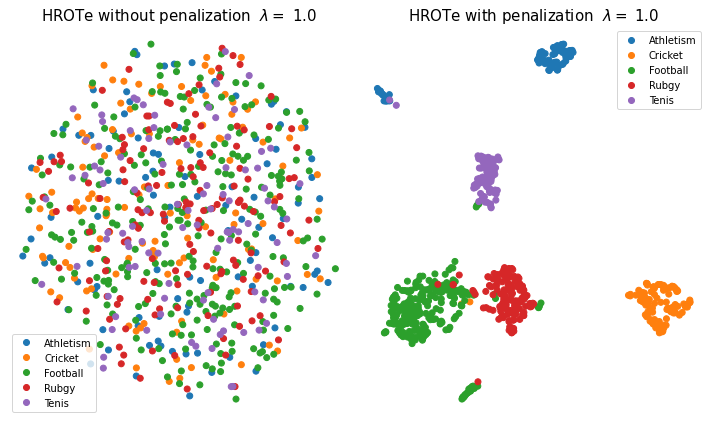

In [34]:
pl.figure(figsize=(10,6))
pl.subplot(1,2,1)
pl.scatter(WMD1_low[:,0],WMD1_low[:,1],c=label_color)
label1 = Line2D([0], [0], label=y_label[0], marker='o', color='C0', linestyle='')
label2 = Line2D([0], [0], label=y_label[1], marker='o', color='C1', linestyle='')
label3 = Line2D([0], [0], label=y_label[2], marker='o', color='C2', linestyle='')
label4 = Line2D([0], [0], label=y_label[3], marker='o', color='C3', linestyle='')
label5 = Line2D([0], [0], label=y_label[4], marker='o', color='C4', linestyle='')
label6 = Line2D([0], [0], label=y_label[4], marker='o', color='C5', linestyle='')
label7 = Line2D([0], [0], label=y_label[4], marker='o', color='C6', linestyle='')
label8 = Line2D([0], [0], label=y_label[4], marker='o', color='C7', linestyle='')
label9 = Line2D([0], [0], label=y_label[4], marker='o', color='C8', linestyle='')
label10 = Line2D([0], [0], label=y_label[4], marker='o', color='C9', linestyle='')
handles, labels = pl.gca().get_legend_handles_labels()
if data_name == 'bbcsport-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4,label5])
elif data_name =='twitter-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3])
elif data_name=='r8-emd_tr_te3.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8])
elif data_name=='amazon-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='classic-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='ohsumed-emd_tr_te_ix.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8,label9,label10])
pl.title("HROTe without penalization  $\lambda =$ %1.1f"%l,size=15)
pl.axis('off')
pl.tight_layout()
pl.legend(handles=handles)
pl.subplot(1,2,2)
pl.scatter(WMD2_low[:,0],WMD2_low[:,1],c=label_color)
label1 = Line2D([0], [0], label=y_label[0], marker='o', color='C0', linestyle='')
label2 = Line2D([0], [0], label=y_label[1], marker='o', color='C1', linestyle='')
label3 = Line2D([0], [0], label=y_label[2], marker='o', color='C2', linestyle='')
label4 = Line2D([0], [0], label=y_label[3], marker='o', color='C3', linestyle='')
label5 = Line2D([0], [0], label=y_label[4], marker='o', color='C4', linestyle='')
label6 = Line2D([0], [0], label=y_label[4], marker='o', color='C5', linestyle='')
label7 = Line2D([0], [0], label=y_label[4], marker='o', color='C6', linestyle='')
label8 = Line2D([0], [0], label=y_label[4], marker='o', color='C7', linestyle='')
label9 = Line2D([0], [0], label=y_label[4], marker='o', color='C8', linestyle='')
label10 = Line2D([0], [0], label=y_label[4], marker='o', color='C9', linestyle='')
handles, labels = pl.gca().get_legend_handles_labels()
if data_name == 'bbcsport-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4,label5])
elif data_name =='twitter-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3])
elif data_name=='r8-emd_tr_te3.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8])
elif data_name=='amazon-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='classic-emd_tr_te_split.mat':
    handles.extend([label1,label2,label3,label4])
elif data_name=='ohsumed-emd_tr_te_ix.mat':
    handles.extend([label1,label2,label3,label4,label5,label6,label7,label8,label9,label10])
pl.axis('off')
pl.tight_layout()
pl.title("HROTe with penalization  $\lambda =$ %1.1f"%l,size=15)
pl.legend(handles=handles)
pl.savefig("../Figures/WMD/HROTe_"+data_name+"_"+str(l)+".pdf",bbox_inches='tight')

## k-NN classif

In [77]:
def knn(M,y,idx_train,idx_test,n_neighbors=7):
    result=0
    for i in idx_test:
        y_neighbors = y[np.argsort(M[i,idx_train])[:n_neighbors]]
        predict = y_neighbors[np.argmax(np.unique(y_neighbors, return_counts=True)[1])]
        # If most popular class is ambiguous try with fewer neighbors; else return
        if predict == y[i]:
            result+=1
    return result/(idx_test.shape[0])

In [129]:
dataset=['bbcsport-emd_tr_te_split.mat','twitter-emd_tr_te_split.mat','r8-emd_tr_te3.mat',
         'amazon-emd_tr_te_split.mat','classic-emd_tr_te_split.mat','ohsumed-emd_tr_te_ix.mat']

dataset=['bbcsport-emd_tr_te_split.mat','twitter-emd_tr_te_split.mat']

n_seed=2
predict=np.zeros((n_seed,len(dataset),6))

In [130]:
l=.1
for j,d in enumerate(dataset):
    print(d)
    WMD=WMD=np.loadtxt("result/WordMoverDistances/WMD_"+d+".txt")
    HOTT=np.loadtxt("result/WordMoverDistances/HOTT_"+d+".txt")
    HOTT=abs(HOTT)
    UOT1=np.zeros(WMD.shape)
    UOT2=np.zeros(WMD.shape)
    UOT1=np.loadtxt("result/WordMoverDistances/UOTP_"+d+"_"+str(l)+".txt") #Only with the plan
    UOT2=np.loadtxt("result/WordMoverDistances/UOT_"+d+"_"+str(l)+".txt") #Plan and divergences
    UOT1,UOT2=abs(UOT1),abs(UOT2)
    UOTe1=np.zeros(WMD.shape)
    UOTe2=np.zeros(WMD.shape)
    #UOTe1=np.loadtxt("result/WordMoverDistances/UOTeP_"+d+"_"+str(l)+".txt") #Only with the plan
    #UOTe2=np.loadtxt("result/WordMoverDistances/UOTe_"+d+"_"+str(l)+".txt") #Plan and divergences
    UOTe1,UOTe2=abs(UOTe1),abs(UOTe2)
    
    idx=np.arange(WMD.shape[0])
    n_neighbors=5
    for i in range(n_seed):
        idx_train,idx_test=train_test_split(idx,test_size=0.25, random_state=None)
        predict[i,j,0]=knn(WMD,y,idx_train,idx_test,n_neighbors)
        predict[i,j,1]=knn(HOTT,y,idx_train,idx_test,n_neighbors)
        predict[i,j,2]=knn(UOT1,y,idx_train,idx_test,n_neighbors)
        predict[i,j,3]=knn(UOT2,y,idx_train,idx_test,n_neighbors)
        predict[i,j,4]=knn(UOTe1,y,idx_train,idx_test,n_neighbors)
        predict[i,j,5]=knn(UOTe2,y,idx_train,idx_test,n_neighbors)
        

bbcsport-emd_tr_te_split.mat
twitter-emd_tr_te_split.mat


In [131]:
predict_mean=np.mean(predict,0)

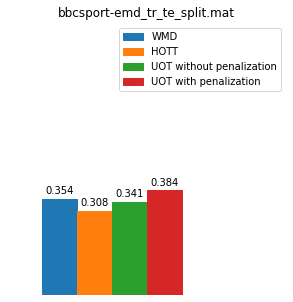

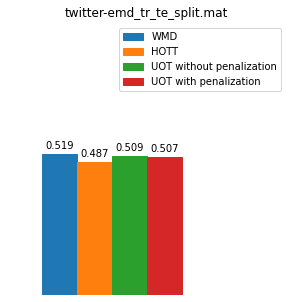

In [132]:
for j,d in enumerate(dataset):
    fig, ax = pl.subplots(figsize=(5,5))
    ax.add_patch(Rectangle((1, 0), 1, predict_mean[j,0],color="C0",label="WMD"))#,label="WMD")
    ax.add_patch(Rectangle((2, 0), 1, predict_mean[j,1],color="C1",label="HOTT"))
    ax.add_patch(Rectangle((3, 0), 1, predict_mean[j,2],color="C2",label="UOT without penalization"))
    ax.add_patch(Rectangle((4,0), 1, predict_mean[j,3],color="C3",label="UOT with penalization"))
    #ax.add_patch(Rectangle((5, 0), 1, predict_mean[j,4],color="C4",label="UOTe without penalization"))
    #ax.add_patch(Rectangle((6, 0), 1, predict_mean[j,5],color="C5",label="UOTe with penalization"))
    pl.text(1.5,predict_mean[j,0]+.03,np.round(predict_mean[j,0],3),fontsize = 10,ha="center",va="center")
    pl.text(2.5,predict_mean[j,1]+.03,np.round(predict_mean[j,1],3),fontsize = 10,ha="center",va="center")
    pl.text(3.5,predict_mean[j,2]+.03,np.round(predict_mean[j,2],3),fontsize = 10,ha="center",va="center")
    pl.text(4.5,predict_mean[j,3]+.03,np.round(predict_mean[j,3],3),fontsize = 10,ha="center",va="center")
    #pl.text(5.5,predict_mean[j,4]+.03,np.round(predict_mean[j,1],3),fontsize = 10,ha="center",va="center")
    #pl.text(6.5,predict_mean[j,5]+.03,np.round(predict_mean[j,2],3),fontsize = 10,ha="center",va="center")
    pl.xlim([0, 8])
    pl.ylim([0, 1])
    pl.legend()
    pl.axis("off")
    pl.xticks([])
    pl.title(d)
    pl.savefig("../Figures/WMD/kNN"+d+"_"+str(l)+".pdf",bbox_inches='tight')
    pl.show()